In [1]:
from pandas import read_csv
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:
X_train_data = read_csv('../X_train_nostring.csv')
X_train_data.fillna(-3, inplace=True)
X_train = X_train_data.values[:,1:]

y_train_data = read_csv('../y_train.csv')
y_train = y_train_data.values[:,1]
for i in range(len(y_train)):
    if y_train[i] == -1:
        y_train[i] = 0

# scaler = StandardScaler()

# X_train = scaler.fit_transform(X_train, y_train)

In [3]:
X_test_data = read_csv('../X_test_nostring.csv')
X_test_data.fillna(-3, inplace=True)
X_test = X_test_data.values[:,1:]

# X_test = scaler.fit_transform(X_test)

In [12]:
# grid search
model = xgb.XGBClassifier(objective="multi:softmax", subsample=0.5, random_state=441)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=441)

#-0.853006 for 62 is min seems
interactions = [62]#[50, 54, 58, 62, 66, 70]   
shrinks =  [0.1]#[1, 0.1, 0.01]
param_grid = dict(max_leaves=interactions, learning_rate=shrinks)

grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

# print results
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean, param in zip(means, params):
 print("%f with: %r" % (mean, param))

print("\nBest: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

-0.853006 with: {'learning_rate': 0.1, 'max_leaves': 62}

Best: -0.853006 using {'learning_rate': 0.1, 'max_leaves': 62}


In [5]:
best_model = xgb.XGBClassifier(objective="multi:softmax", subsample=0.5, random_state=441, max_leaves=62, learning_rate=0.1).fit(X_train, y_train)
prob = best_model.predict_proba(X_test)

In [6]:
test = np.c_[ np.ones(11438), prob ]              # add a column

for i in range(len(test)):
    test[i][0] = i

np.savetxt('xgb.csv', test, delimiter=',', header="id,no answer,very important,quite important,not important,not at all important", comments="", fmt='%1.4f') 

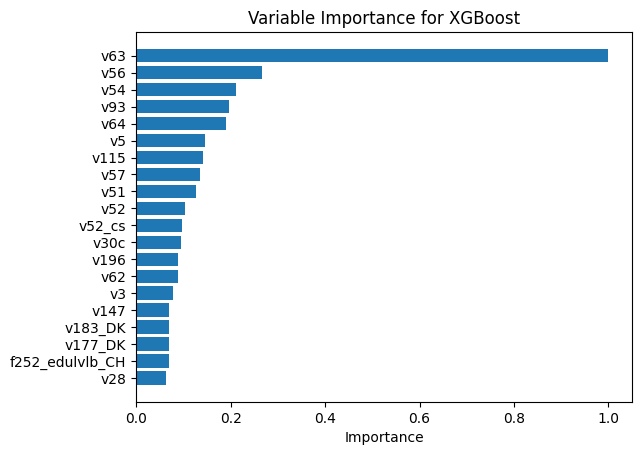

In [7]:
importance = best_model.feature_importances_

# Sort and standardize
names = X_train_data.columns[1:]
max = importance.max()
standard_importance = [x / max for x in importance]
label = dict(sorted(zip(names, standard_importance),  key=lambda x: x[1])[-20:])

plt.barh(list(label.keys()), list(label.values()))
plt.xlabel("Importance")
plt.title("Variable Importance for XGBoost")
plt.show()

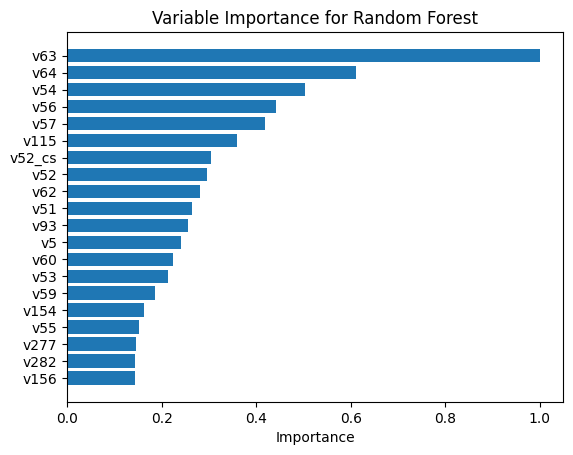

In [8]:
rfmodel = RandomForestClassifier(random_state=441, oob_score=True, criterion = 'log_loss')
rfmodel.fit(X_train, y_train)
rf_acc = rfmodel.oob_score_
rfimportance = rfmodel.feature_importances_

# Sort and standardize
m = rfimportance.max()
standard = [x / m for x in rfimportance]
label = dict(sorted(zip(names, standard),  key=lambda x: x[1])[-20:])

plt.barh(list(label.keys()), list(label.values()))
plt.xlabel("Importance")
plt.title("Variable Importance for Random Forest")
plt.show()

In [9]:
rfmodel.predict_proba(X_test)

array([[0.01, 0.25, 0.3 , 0.32, 0.12],
       [0.  , 0.22, 0.58, 0.2 , 0.  ],
       [0.01, 0.23, 0.48, 0.24, 0.04],
       ...,
       [0.  , 0.22, 0.44, 0.28, 0.06],
       [0.02, 0.05, 0.33, 0.48, 0.12],
       [0.  , 0.69, 0.25, 0.05, 0.01]])